In [3]:
import os
import matplotlib.pyplot as plt
import spacy

nlp = spacy.load("en_core_web_sm")
# doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

In [15]:
def find_verb(sent):
    """ Find verb/root, works only for English. """
    to_remove = ['[SEP]', '[CLS]', '<pad>']
    sent = sent.replace(' ##', '')
    temp = [x for x in sent.strip().split(' ') if not x in to_remove]
    
    doc = nlp(' '.join(temp))
    head = False
    head_idx = False
    for num, token in enumerate(doc):
        if token.pos_ == 'VERB' and token.dep_ == 'ROOT':
            head = token.text
            head_idx = num
    if not head:
        for token in doc:
            if token.dep_ == 'ROOT':
                head = token.text
                head_idx = num

    return temp, head, head_idx

In [4]:
# see all the BERT models for telicity

marker = 'telicity'
model = 'bert'

# files = [f for f in os.listdir(os.getcwd()) if f.endswith('.log') 
#          if f.startswith(marker) if f.split('_')[1].startswith('bert')]
files = ['telicity_bert-base-cased_yes.log']

sents = {}
for f in files:
    sents[f] = {}
    with open(f, 'r') as file:
        wrong = []
        right = []

        for line in file:
            if line.startswith('wrong label:'):
                l = line.strip().split('\t')
                wrong.append([int(l[0][-1]), # label
                              float(l[1][7:-1].split(', ')[int(l[0][-1])]), # prob of prediction
                              l[2]] # sent)
            elif line.startswith('right label:'):
                right.append([int(l[0][-1]), 
                              float(l[1][7:-1].split(', ')[int(l[0][-1])]),
                              l[2]])

    sents[f]['wrong'] = wrong
    sents[f]['right'] = right


In [16]:
# Show 10 sentences for which the models were confident but wrong

for f, v in sents.items():
    print('\n===== ' + f[:-4] + ' =====')
    wrong_telic = []
    wrong_atelic = []
    for sent in v['wrong']:
        if sent[0] == 0 and sent[1] > 0.8:
            wrong_telic.append(sent[2])
        elif sent[0] == 1 and sent[1] > 0.8:
            wrong_atelic.append(sent[2])
            
    print('Wrong Telic:')
    for s in wrong_telic[:10]:
        #print('\t', s)
        print(find_verb(s))
    
    print('\nWrong Atelic:')
    for s in wrong_atelic[:10]: 
        #print('\t', s)
        print(find_verb(s))


===== telicity_bert-base-cased_yes =====
Wrong Telic:
(['I', 'would', 'wake', 'late', ',', 'checking', 'the', 'clock', 'on', 'my', 'room', "'", 's', 'lightscreen', 'to', 'make', 'sure', 'I', 'had', 'n', "'", 't', 'slept', 'through', 'brunch', '.'], 'wake', 2)
(['They', 'began', 'the', 'process', 'of', 'building', 'their', 'strong', 'citadels', ',', 'and', 'reinforcing', 'the', 'Christian', 'faith', 'on', 'the', 'islands', '.'], 'began', 1)
(['Youll', 'be', 'used', 'to', 'the', 'sensation', 'in', 'a', 'moment', '.', '”', 'That', 'just', 'unnerved', 'me', 'more', '.'], 'unnerved', 14)
(['It', 'wont', 'refill', 'your', 'blood', 'supply', ',', 'but', 'while', 'thats', 'in', 'your', 'system', ',', 'you', 'wont', 'even', 'need', 'blood', '.', '”', 'He', 'grinned', 'at', 'me', '.'], 'grinned', 25)
(['But', 'we', 'see', 'new', 'faces', '.', '”', 'You', "'", 're', 'sure', 'it', "'", 's', 'not', 'just', 'some', 'people', 'being', 'indisposed', '?'], 're', 9)
(['I', 'did', 'not', 'ask', 'questio


telicity_bert-base-cased_yes


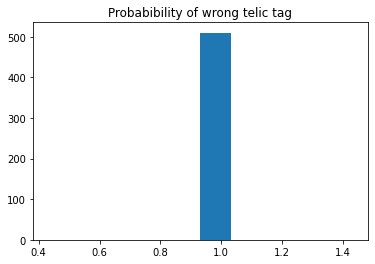

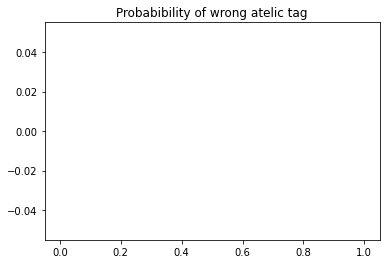

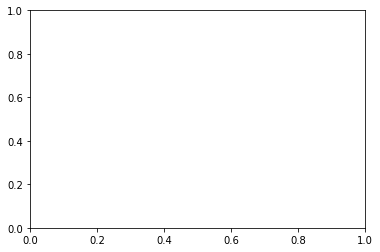

In [16]:
# Print histograms of probabilities

for f, v in sents.items():
    print()
    print(f[:-4])
    wrong_telic = []
    wrong_atelic = []
    for sent in v['wrong']:
        if sent[0] == 0:
            wrong_telic.append(sent[1])
        else:
            wrong_atelic.append(sent[1])
            

    plt.title('Probabibility of wrong telic tag')
    plt.hist(wrong_telic)
    plt.show()
    plt.cla()

    plt.title('Probabibility of wrong atelic tag')
    plt.hist(wrong_atelic)
    plt.show()
    plt.cla()

/users/melodi/emetheni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


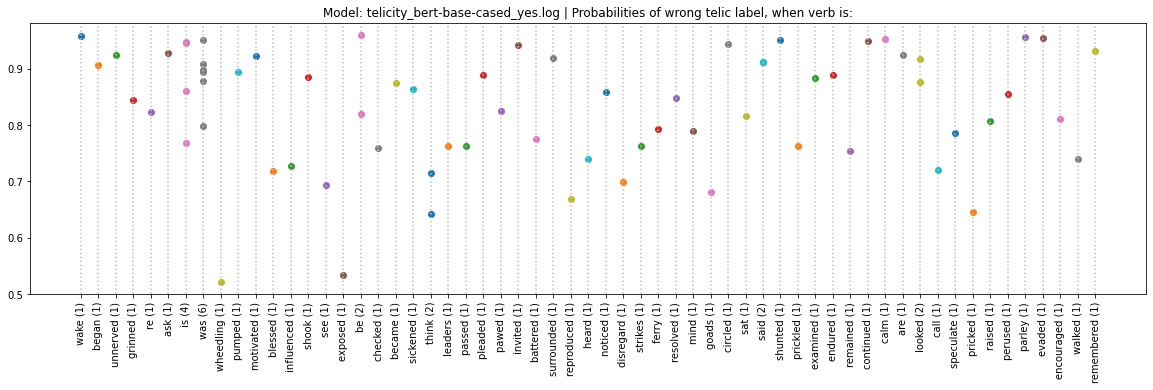

/users/melodi/emetheni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


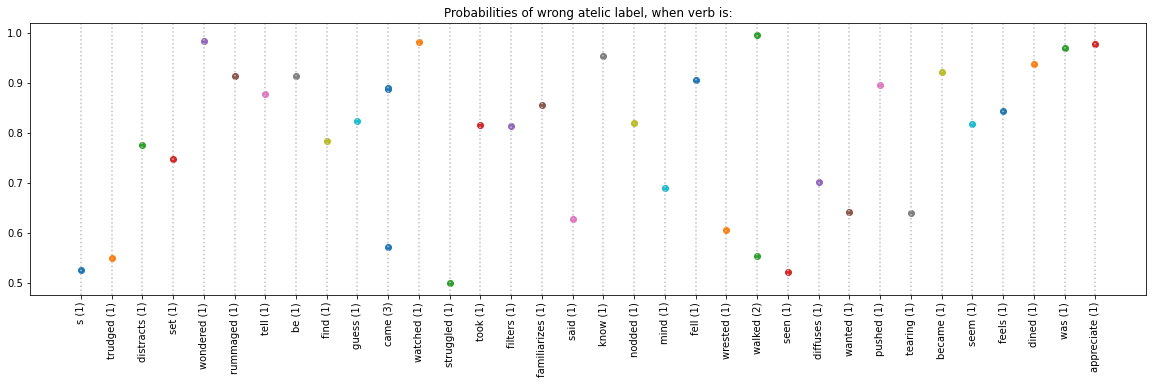

In [35]:
# Find verbs and print distr of verbs-probs

for f, v in sents.items():
    
    wrong_telic_verbs = {}
    wrong_atelic_verbs = {}
    
    for sent in v['wrong']:
        s, verb, verb_idx = find_verb(sent[2])
        if sent[0] == 0:
            if not verb in wrong_telic_verbs:
                wrong_telic_verbs[verb] = []
            wrong_telic_verbs[verb].append(sent[1])
        elif sent[0] == 1:
            if not verb in wrong_atelic_verbs:
                wrong_atelic_verbs[verb] = []
            wrong_atelic_verbs[verb].append(sent[1])
            
# Plot wrong telic verbs

x = [n for n in range (len(wrong_telic_verbs))]
y = [v for v in wrong_telic_verbs.values()]

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
for xe, ye in zip(x, y):
    plt.axvline(xe, 0, 1, color='silver', linestyle=':')
    plt.scatter([xe] * len(ye), ye)

plt.title('Model: ' + f + ' | Probabilities of wrong telic label, when verb is:')
labels = [k + ' (' + str(len(v)) + ')' for k, v in wrong_telic_verbs.items()]
plt.xticks(x, rotation=90)
plt.axes().set_xticklabels(labels)
plt.show()

# Plot wrong atelic verbs

x = [n for n in range (len(wrong_atelic_verbs))]
y = [v for v in wrong_atelic_verbs.values()]

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
for xe, ye in zip(x, y):
    plt.axvline(xe, 0, 1, color='silver', linestyle=':')
    plt.scatter([xe] * len(ye), ye)

plt.title('Probabilities of wrong atelic label, when verb is:')
labels = [k + ' (' + str(len(v)) + ')' for k, v in wrong_atelic_verbs.items()]
plt.xticks(x, rotation=90)
plt.axes().set_xticklabels(labels)
plt.show()